In [1]:
import numpy as np
import scipy.io
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.optimize import fsolve
from scipy.optimize import leastsq
from scipy.signal import find_peaks
from scipy.integrate import solve_ivp
import scipy as sp

import warnings
warnings.filterwarnings('ignore')

# Plots setup 
from matplotlib import rc

rc('text', usetex=True)
plt.rcParams['text.latex.preamble'] = [
    r'\usepackage{tgheros}',    # helvetica font
    r'\usepackage{sansmath}',   # math-font matching  helvetica
    r'\sansmath'                # actually tell tex to use it!
    r'\usepackage{siunitx}',    # micro symbols
    r'\sisetup{detect-all}',    # force siunitx to use the fonts
]  
plt.rcParams.update({"font.size": 18})
plw = 0.6
pcs = 3
pms = 3
bfillc = [0.9,0.9,0.9]
plt.rcParams['axes.linewidth'] = plw
plt.rcParams['xtick.top'] = True
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['xtick.major.width'] = plw
plt.rcParams['xtick.minor.width'] = plw
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['xtick.major.size'] = 4.5
plt.rcParams['ytick.right'] = True
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['ytick.major.width'] = plw
plt.rcParams['ytick.minor.width'] = plw
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['ytick.major.size'] = 5
plt.rcParams["figure.figsize"] = (5,4)

from matplotlib.ticker import (MultipleLocator,
                               FormatStrFormatter,
                               AutoMinorLocator)


# Thermodynamics and kinetics of Liquid/Liquid phase separation in confined volumes.

Lunna Li and Matteo Salvalaglio

_Last updated 23/06/2022_

This notebook reports the theoretical underpinnings and implementation of the analysis of microfluidic experiments reported in: 

- _Droplet microfluidics for the label-free extraction of complete phase diagrams and kinetics of liquid-liquid phase separation in finite volumes_ Alessia Villois, Umberto Capasso Palmiero, Prerit Mathur, Gaia Perone, Timo Schneider, Lunna Li, Matteo Salvalaglio,Andrew deMello, Stavros Stavrakis, Paolo Arosio, 2022, _submitted_


## Thermodynamic driving force for L/L phase separation: 1. Peptide Chemical Potential
Let's consider two liquid phases, $\ell$ diluited in component $i$ (the peptide or polymer), and $L$ dense in $i$. The chemical potential of species $i$ in the dilute phase, can be written as: 

\begin{equation}
\mu_i^{\ell}=\mu_0+RT\ln{a_i^\ell}
\end{equation}

where $\mu_0$ is a reference chemical potential and ${a_i^\ell}$ is the activity of $i$ in the dilute phase. Analogously, the chemical potential of $i$ in the dense phase $L$ in equilibrium with $\ell$ at temperature T and pressure P can be written as: 

\begin{equation}
\mu_i^{L}=\mu_0+RT\ln{a_i^{\ell,*}}
\end{equation}

where $a_i^{\ell,*}$ is the activity of $i$ in $\ell$ at equilibrium $*$. In the following we shall consider $i$ as the polymer, and drop subscript $i$ for the sake of compactness. 

The thermodynamic driving force associated to the $\ell/L$ phase transition can therefore be written as: 

\begin{equation}
\Delta\mu_{\ell\rightarrow{L}}=-RT\ln\frac{a^{\ell}}{a^{\ell,*}}\simeq -RT\ln\frac{c^{\ell}}{c^{\ell,*}}-\Delta\mu^E_{\ell\rightarrow{L}}
\end{equation}

Where $c^\ell$ and $c^{\ell,*}$ are the concentrations in a parent diluite phase, and at equilibrium, while $\Delta\mu^E_{\ell\rightarrow{L}}$ is the excess free energy difference associated to the phase transition between the diluite and dense phases. 

Consider a system in which the dilute phase is supersaturated with respect to the ${\ell\rightarrow{L}}$ transition $\left(\frac{c^{\ell}}{c^*_{\ell}}>1\right)$ and confined in a finite, small volume $V_{tot}$.

Such a system evolves towards equilibirum by nucleating the dense phase $L$. Progressing towards equilibrium, the volume of the dense phase $V_D$ increases, depleting the parent dilute phase $\ell$ of solute $i$.
In these conditions, the driving force $\Delta\mu^{\ell\rightarrow{L}}$ becomes a function of $V_{D}$ and $V_{tot}$. 

\begin{equation}
\Delta\mu^{\ell\rightarrow{L}}(V_D)=-RT\ln\frac{c_{tot}-\rho_LV^*_D}{c^*_{\ell}\left(1-V^*_D\right)}-\Delta\mu^E_{\ell\rightarrow{L}}
\end{equation}

where $\rho_L$ is the concentration of i in the dense phase at the T and P of the system, and $V^*_D=V_D/V_{tot}$. 

## Thermodynamic driving force for L/L phase separation: 2. Solvent Chemical Potential

As for the solute, when a phase transition takes place in a confined volume this has an effect also on the chemical potential of the solvent, which in turn contributes to the definition of the thermodynamic equilibrium of a dense liquid droplet formed within a small, confined volume $V_{tot}$. 
The difference in chemical potential of the solvent (superscript $s$) between a state at arbitrary peptide concentration $c^\ell$ and a dense phase in equilibrium conditions at the assigned values of T and P can be written as: 

\begin{equation}
\Delta{\mu}^s_{\ell\rightarrow{L}}=-RT\ln\frac{a^{s,\ell}}{a^{s,\ell,*}}\simeq-RT\ln\frac{1-x^{\ell}}{1-x^{\ell,*}}=-RT\ln\frac{1-\frac{c_{tot}-\rho_LV^*_D}{c_WM_p\left(1-V^*_D\right)}}{1-\frac{c_{eq}^\ell}{c_WM_p}}
\end{equation}

where $c_W$ is the total molar solvent (water) concentration and $M_p$ the molar mass of the peptide. 

## Reversible work for the formation of a dense liquid droplet and equilibrium conditions in a finite-size droplet

By introducing an excess free energy term associated with the formation of an interface between the dense and diluite phases, we can now write the (adimensional) reversible work of formation of a dense liquid droplet $F^\prime$. The excess surface free energy can be expressed introducing a free energy penalty proportional to the surface per unit volume of the dense liquid droplet via a surface tension term $\sigma$, as typically done in Classical Nucleation Theory. Here we consider the dense liquid phase droplet to be spherical in shape. 

\begin{equation}
F^\prime=\frac{M_p\,F}{\rho^LV_{tot}RT}=
-V^*_D\left[\ln\frac{c_{tot}-\rho_LV^*_D}{c^{\ell,*}\left(1-V^*_D\right)}+\frac{\Delta{\mu}^E}{RT}\right]
+\sigma^\prime\left(3V^*_D\right)^{2/3}\left(\frac{4\pi}{V_{tot}}\right)^{1/3}
\end{equation}
\begin{equation}
-\frac{\rho_Lc_w}{M_p}(1-V^*_D)\left[\ln\left({1-\frac{c_{tot}-\rho_LV^*_D}{c_WM_p\left(1-V^*_D\right)}}\right)-\ln\left({{1-\frac{c^*_{\ell}}{c_WM_p}}}\right)\right]
\end{equation}

Here $M_p$ is the molar mass of the polymer, $\rho_L$ is the density of the dense phase, $c_w$ is the total molar concentration of the solvent (water in this case), $\sigma^\prime$ is a normalized surface tension of the dense liquid defined as: $\sigma^\prime=\frac{\sigma M_p}{\rho^LRT}$, where $\sigma$ is the surface tension, and $\left(3V^*_D\right)^{2/3}\left(\frac{4\pi}{V_{tot}}\right)^{1/3}$ is the surface area of a droplet of volume $V_D$ divided by its total volume $V_{tot}$. 

The reversible work $F^\prime$ is a non-monotonic function of the droplet size that admits at least one stationary point, corresponding to the equilibrium (in certain cases metastable) conditions for a droplet of dense liquid immersed in a dilute parent phase. 

In $F^\prime$, since $c_wM_p>>c_{eq}^\ell,c_{tot}$ and $V_D^*$ the contribution associated with the solvent change in chemical potential is negligible, and hence the reversible work associated to the formation of a droplet reduces to: 

\begin{equation}
F^\prime=\frac{M_p\,F}{\rho^LV_{tot}RT}\simeq
-V^*_D\left[\ln\frac{c_{tot}-\rho_LV^*_D}{c^*_{\ell}\left(1-V^*_D\right)}+\frac{\Delta{\mu}^E}{RT}\right]
+\sigma^\prime\left(3V^*_D\right)^{2/3}\left(\frac{4\pi}{V_{tot}}\right)^{1/3}
\end{equation}

## Steady state droplet conditions

The local minimum of the reversible work of droplet formation identifies the steady state, equilibrium condition for a droplet of dense phase $L$, that nucleates and grows from a dilute phase of volume $V_{tot}$ and initial concentration $c_{tot}$. 

The local minimum is either the sole stationary point of the reversible work function, or the stationary point corresponding to the largest $V_D^*$. When present,the stationary point corresponding to the local maximum of the free energy function represents the critical nucleus volume, associated with the nucleation of the dense liquid phase in a given thermodynamic state defined by assigned $T$, $P$, $c_{tot}$ and $V_{tot}$. 

At steady state conditions (where $V_D^*=V_D^{*,ss}$, $V_D^{*,ss}$ is the dense phase normalised droplet volume measured from experiments in the long time limit), the mean thermodynamic force acting on the dense phase droplet is null. This condition corresponds to a stationary point in the free energy curve, where $\frac{dF^\prime}{dV_D^*}=0$, and the following expression holds: 

\begin{equation}
\frac{dF^\prime}{dV_D^*}=-\ln \left[\frac{c_{tot} - \rho_LV_D^*}{c^*_{\ell}(1 - V_D^*)}\right] -\frac{\Delta\mu^E_{\ell\rightarrow{L}}}{RT} + \frac{V_D^* (\rho_L - c_{tot})}{(V_D^* - 1) (\rho_L V_D^* - c_{tot})}+  \frac{2 \sigma^\prime(4\pi/V_{tot})^{1/3}}{(3V_D^*)^{1/3}}=0
\end{equation}

### Fig.1 Reversibe work of droplet formation.

In [2]:
#Define Functions -> Free Energy
F=lambda VDstar, SIGMAprime, DmuE, Ctot, rhoL, Ceq, Vtot, :\
                                            +SIGMAprime*np.power((3*VDstar),2/3)*np.power((4*np.pi/Vtot),1/3) \
                                            -VDstar*(np.log((Ctot-rhoL*VDstar)/(Ceq*(1-VDstar)))+DmuE*((1-Ctot/Ceq))) # 
                                                    
#Define Functions -> Mean Thermodynamc Force
dFdV=lambda VDstar, SIGMAprime, DmuE, Ctot, rhoL, Ceq, Vtot, : \
                                            -DmuE*(1-Ctot/Ceq)-np.log((Ctot - rhoL * VDstar )/(Ceq - Ceq* VDstar)) \
                                            + (VDstar * (rhoL - Ctot))/((VDstar - 1) * (rhoL * VDstar - Ctot)) \
                                            + (2 * SIGMAprime*np.power((4*np.pi/Vtot),1/3))/(np.power(3*VDstar,(1/3)))

#Define Functions -> Nucleation Free Energy, Macroscopic limit
Fmacro=lambda VDstar, SIGMAprime, DmuE, Ctot, Ceq, Vtot, : \
                                            +SIGMAprime*np.power((3*VDstar),2/3)*np.power((4*np.pi/Vtot),1/3) \
                                            -VDstar*(np.log((Ctot)/(Ceq))+DmuE*(1-Ctot/Ceq))

#Define Functions -> Mean Thermodynamc Force, macroscopic limit
dFdVmacro=lambda VDstar, SIGMAprime, DmuE, Ctot, Ceq, Vtot, : \
                                            -(1-Ctot/Ceq)*DmuE-np.log((Ctot)/(Ceq)) \
                                            + (2 * SIGMAprime*np.power((4*np.pi/Vtot),1/3))/(np.power(3*VDstar,(1/3)))

#Define Functions -> Critical Normalised Droplet Volume (macroscopic)
criticalVmacro=lambda SIGMAprime, DmuE, Ctot, Ceq, Vtot, : \
                                            1/3 * np.power(2*SIGMAprime*np.power(4*np.pi/Vtot,1/3) / (np.log(Ctot/Ceq) + DmuE*(1-Ctot/Ceq)),3)

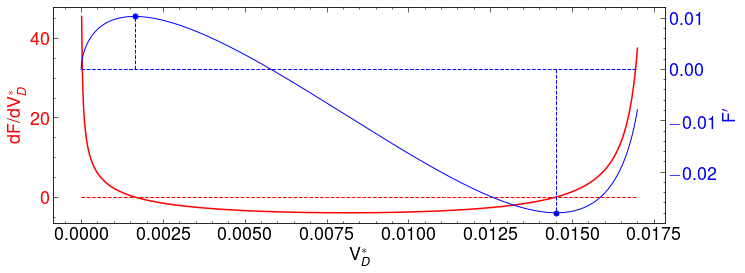

In [3]:
# I am using order of magnitude values from illutrative purposes. 
VDstar=np.linspace(0,0.017,1000)
Ctot=12 #g/l
rhoL=689 #g/l
Vtot=2.67947E-10 #L
Cw=55.5 # mol/l
Mp=58230 # g/mol

# This is a guess, these parameters will be fitted on experimental data. 
sigmaprime=3.E-4#
DmuE=-0.95
Ceq=1 #mg/ml

#figure
figure=plt.figure()
ax2 = figure.add_axes([0.1,0.1,1.7,0.75])
ax2.tick_params(axis ='y', labelcolor = 'red') 

#analytical derivative
plt.plot(VDstar,dFdV(VDstar,sigmaprime, DmuE,  Ctot, rhoL, Ceq, Vtot),'-r',markersize=5)
plt.show
plt.plot(VDstar,np.zeros(np.shape(VDstar)),'r--',linewidth=1)


ax1 = ax2.twinx() 
ax1.set_ylabel('F$^\prime$', fontsize=18, color='blue')
ax1.plot(VDstar,np.zeros(np.shape(VDstar)),'b--',linewidth=1)
ax1.plot(VDstar,F(VDstar, sigmaprime, DmuE, Ctot, rhoL, Ceq, Vtot),'b',linewidth=1)
Ftot=F(VDstar, sigmaprime, DmuE, Ctot, rhoL, Ceq, Vtot);
ax1.plot(VDstar[np.argmax(Ftot[0:np.argmin(Ftot)])],np.max(Ftot[0:np.argmin(Ftot)]),'ob',markersize=5)
ax1.plot(VDstar[np.argmin(Ftot)],np.min(Ftot),'ob',markersize=5)
ax1.plot((VDstar[np.argmin(Ftot)], VDstar[np.argmin(Ftot)]),(0, np.min(Ftot)),'b--',linewidth=1)
ax1.plot((VDstar[np.argmax(Ftot[0:np.argmin(Ftot)])], VDstar[np.argmax(Ftot[0:np.argmin(Ftot)])]),(0, np.max(Ftot[0:np.argmin(Ftot)])),'b--',linewidth=1)


ax1.tick_params(axis ='y', labelcolor = 'blue') 
#plt.xscale('log')
ax2.set_ylabel('dF/dV$_D^*$', fontsize=18, color='red');
ax2.set_xlabel('V$_D^*$',fontsize=18);
plt.savefig('panel_1_model', dpi=600, bbox_inches='tight')

## Obtaining physical properties from steady state droplet conditions. 

From the condition of null thermodynamic force at steady state: 

\begin{equation}
-\ln \left[\frac{c_{tot} - \rho_LV_D^*}{c_i^{\ell,*}(1 - V_D^*)}\right] -\frac{\Delta\mu^E_{\ell\rightarrow{L}}}{RT} + \frac{V_D^* (\rho_L - c_{tot})}{(V_D^* - 1) (\rho_L V_D^* - c_{tot})}+  \frac{2 \sigma^\prime(4\pi/V_{tot})^{1/3}}{(3V_D^*)^{1/3}}=0
\end{equation}

we note that parameters $c_{tot}$, $\rho_L$, and $V_{tot}$ are known and dependent on the experimental setup. The dense phase droplet volume $V_D^*=V_D^{*,ss}$, and the equilibrium concentration $c^{\ell,*}$ are obtained from direct imaging and mass-balance analysis of the experiments, respectively.
Here we impose a surface tension of the order of magnitude of $10^{-4}$-$10^{-6}$. 

This choice allows us to use $-\Delta\mu^E_{\ell\rightarrow{L}}/RT$ to fit the experimental observations gathered at all T and compositions. 

We note that $\Delta\mu^E_{\ell\rightarrow{L}}/RT$ goes to zero for $T\rightarrow{T_c}$, and for $c\rightarrow{c_{eq}(T)}$. 
Here we capture these constraints by expressing $\Delta\mu^E_{\ell\rightarrow{L}}/RT$ as: 

\begin{equation}
\frac{\Delta\mu^E_{\ell\rightarrow{L}}}{RT}=\frac{\Delta\mu^E_0}{R}\left(\frac{1}{T}-\frac{1}{T_c}\right)\left(1-\frac{c_{tot}}{c^*_{\ell}}\right)
\end{equation}

where $\Delta\mu^E_0$ is a fitting parameter.  

The errorbars on $\Delta\mu^E_0$ represent the standard error of the mean estimate obtained from fitting computed via bootstrap analysis.  

In [4]:
# Redefine dFdV for optimization
# Error function
    # rhoL: density of the dense phase, constant with T
    # Vtot: total volume, constant in m^3
    # tpl: tuple of fitted parameters, tpl[0]: Gamma*Ceq, tpl[1]:sigma_prime
    # x,y: experimental data at constant T and different Ctot. x=VDstar, y=Ctot
ERR=lambda tpl, VDstar, Ctot, rhoL, Ceq, Vtot, T, SIGMAprime : \
                                -(tpl[0]*np.power(1/(273.15+T)-1/(273.15+50),1))*(1-Ctot/Ceq)-np.log((Ctot - rhoL * VDstar )/(Ceq - Ceq* VDstar)) \
                                + (VDstar * (rhoL - Ctot))/((VDstar - 1) * (rhoL * VDstar - Ctot)) \
                                + (2 * SIGMAprime *np.power((4*np.pi/Vtot),1/3))/(np.power(3*VDstar,(1/3)))



# Temperature Ci,tot (g/L) VD* Vtot (L) ci,l,* (g/L) rhoL (g/L)
ETH_data=np.array([(27,12,0.011878717,2.67947E-10,3.7,689),
                  (27,20,0.02371227,2.67947E-10,3.7,689),
                  (27,26.05,0.032129806,2.67947E-10,3.7,689),
                  (30,12,0.01112096,2.67947E-10,4.3,687),
                  (30,20,0.022498935,2.67947E-10,4.3,687),
                  (30,26.05,0.031448302,2.67947E-10,4.3,687),
                  (33,12,0.006755833,2.67947E-10,8,580),
                  (33,20,0.020388839,2.67947E-10,8,580),
                  (33,26.05,0.030645302,2.67947E-10,8,580), 
                  (37,12,0.00060651,2.67947E-10,12,513),
                  (37,20,0.013998702,2.67947E-10,12,513),
                  (37,26.05,0.027360151,2.67947E-10,12,513)])
                  
Nexperiments=np.shape(ETH_data)[0]

#Surface tension 
SIGMA=1E-2; #N/m

#N/m to dimensionless surface tension. 
MM=58230 #g/mol
R=8.314 #J/mol
TK=(273.15+ETH_data[:,0]) #K
RT=R*TK

SIGMAprime=SIGMA/RT/ETH_data[:,5]*MM/1E2 # J/dm^2

## Analysis of ETH dataset for UCST, 150 mM NaCl - 1 Fitted parameters

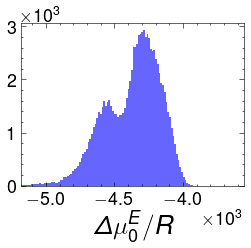

In [5]:
# c=0
T=np.zeros(4)
RHOL=np.zeros(4)
Factor=np.zeros(4)
Ceqexp=np.zeros(4)
VT=np.zeros(4)

REPS=100000
MU0=np.zeros(REPS)

#Bootstrapping-like error calculation with random selection of N experiments with repetition
for REP in np.arange(0,REPS):
    #Randomise Initial Guess
    guess=100
    #choose 12 random experiments (with repetition)
    experiments=np.random.randint(0,Nexperiments,Nexperiments)   

    #least squares fitting
    #tplFitted => tuple of fitted parameters
    tplFitted,success=leastsq(ERR,guess,args=(ETH_data[experiments,2],\
                                              ETH_data[experiments,1],\
                                              ETH_data[experiments,5],\
                                              ETH_data[experiments,4],\
                                              ETH_data[experiments,3],\
                                              ETH_data[experiments,0],\
                                              SIGMAprime),\
                                              full_output=0,maxfev=1000,ftol=1E-15,gtol=1E-15)  
   

    MU0[REP]=tplFitted[0]

fig,ax = plt.subplots(1,1,figsize=(4,3))

ax.hist(MU0, bins = 'auto',alpha=0.6,color='blue')
ax.set_xlabel('${\Delta\mu^E_0}/{R}$',fontsize=26)
ax.set_xlim([np.average(MU0)-4*np.std(MU0), np.average(MU0)+4*np.std(MU0)])
plt.ticklabel_format(axis='both', style='sci', scilimits=(-2,2))
plt.savefig('panel_2_parameters', dpi=600, bbox_inches='tight');



## Analysis of ETH dataset for UCST, 150 mM NaCl - 3 Nucleation (Coalescence(?)) Barriers and Critical Droplet Volume fraction in experiments

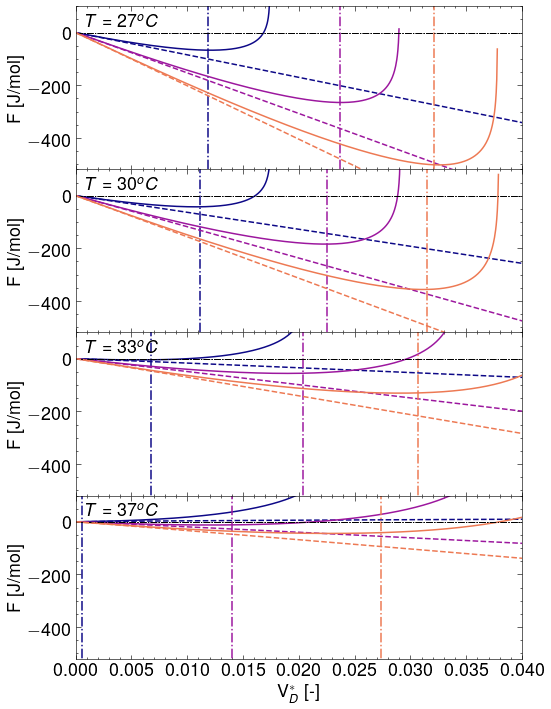

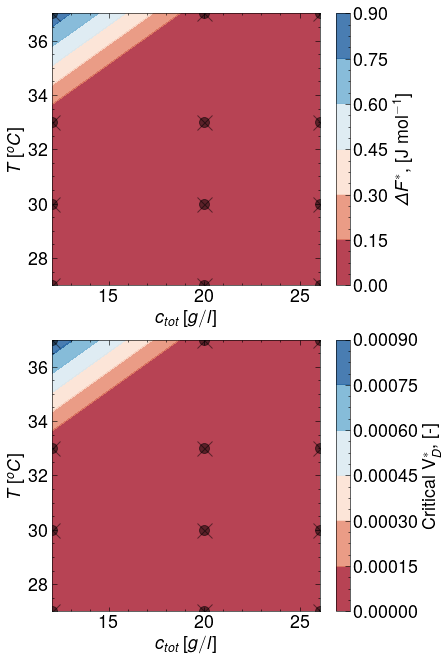

In [7]:
# Clean UP experimental parameters
T_exp=ETH_data[([0,3,6,9]),0]
Ctot_exp=ETH_data[0:3,1]
VDstar_exp=ETH_data[:,2]
Vtot_exp=ETH_data[0,3]
Ceq_exp=ETH_data[([0,3,6,9]),4]
rhoL_exp=ETH_data[([0,3,6,9]),5]

#value of fitted parameters in experimental conditions 
SIGMAprime_exp=SIGMAprime[([0,3,6,9])]
DmuE_exp=DmuE[([0,3,6,9])]

#parameters
BARRIER=np.zeros([4,3])
CRITICAL_VOLUME=np.zeros([4,3])
BARRIER_macro=np.zeros([4,3])
CRITICAL_VOLUME_macro=np.zeros([4,3])
CT_g,Ceq_g = np.meshgrid(Ctot_exp, Ceq_exp) 
CT_g,T_g   = np.meshgrid(Ctot_exp, T_exp) 
fig, axs = plt.subplots(4,1,figsize=(8,12),sharex=True,gridspec_kw={'hspace': 0})

VDstar_v=np.linspace(0,0.05,1000)
cc=0
# Cycle over Temperatures
for i in np.arange(0,np.size(T_exp)): 
    # Color for different Ctot_s
    color=iter(cm.plasma(np.linspace(0,1,1+np.size(Ctot_exp))))
    
    # Cycle over Concentrations
    for j in np.arange(0,np.size(Ctot_exp)):
        guess=1E-8
        c=next(color)
        
        # Find zeros of dFdV with fixed parameters (gamma and DmuE) => Critical VDstar
        CRITICAL_VOLUME[i,j],success=leastsq(dFdV,guess,args=(SIGMAprime_exp[i], DmuE_exp[i], Ctot_exp[j], rhoL_exp[i], Ceq_exp[i], Vtot_exp),\
                                 full_output=0,maxfev=1000,ftol=1E-15,gtol=1E-15)  
        
        
        # Compute Free energy barrier   
        BARRIER[i,j]= R*(273.15+T_exp[i]) * F(CRITICAL_VOLUME[i,j],SIGMAprime_exp[i], DmuE_exp[i], Ctot_exp[j], rhoL_exp[i], Ceq_exp[i], Vtot_exp) 
        #axs[i].plot([CRITICAL_VOLUME[i,j], CRITICAL_VOLUME[i,j]],[0, BARRIER[i,j]],'r-')
       
        # Plot 
        axs[i].plot([VDstar_exp[cc],VDstar_exp[cc]],[-700,500],'-.',c=c)
        axs[i].plot(VDstar_v,R*(273.15+T_exp[i]) * F(VDstar_v,SIGMAprime_exp[i], DmuE_exp[i], Ctot_exp[j], rhoL_exp[i], Ceq_exp[i], Vtot_exp),c=c)  
        axs[i].plot([0,0.04],[0,0],'k-.',linewidth=1)
        axs[i].set_ylim([-520,100])
        axs[i].set_xlim([0,0.04])
        
        axs[i].plot(VDstar_v,R*(273.15+T_exp[i])*Fmacro(VDstar_v,SIGMAprime_exp[i], DmuE_exp[i], Ctot_exp[j], Ceq_exp[i], Vtot_exp),'--',c=c)  
        axs[i].set_ylabel('F [J/mol]')
        cc=cc+1
        
axs[0].text(0.0008,25,'$T=27^oC$')
axs[1].text(0.0008,25,'$T=30^oC$')
axs[2].text(0.0008,25,'$T=33^oC$')
axs[3].text(0.0008,25,'$T=37^oC$')
axs[3].set_xlabel('V$_D^*$ [-]')
plt.savefig('FittedFES', dpi=600, bbox_inches='tight')

fig, ax = plt.subplots(2, 1,figsize=(6,11))

cp=ax[0].contourf(CT_g,T_g,BARRIER,cmap='RdBu',antialiased=False,alpha=0.8);
cbar = plt.colorbar(cp, ax=ax[0])
cbar.set_label("$\Delta{F^*}$, [J mol$^{-1}$]")
#ax[0].set_title('$Nucleation Free Energy Barrier$')
ax[0].set_ylabel('$T\,[^oC]$')
ax[0].set_xlabel('$c_{tot}\,[g/l]$')
ax[0].plot(CT_g,T_g,'ko',markersize=10,alpha=0.5)
ax[0].plot(CT_g,T_g,'kx',markersize=15,alpha=0.5)

cp=ax[1].contourf(CT_g,T_g,(CRITICAL_VOLUME),cmap='RdBu',antialiased=False,alpha=0.8);
cbar = plt.colorbar(cp, ax=ax[1])
cbar.set_label("Critical V$_D^*$, [-]")
ax[1].set_ylabel('$T\,[^oC]$')
ax[1].set_xlabel('$c_{tot}\,[g/l]$')
ax[1].plot(CT_g,T_g,'ko',markersize=10,alpha=0.5)
ax[1].plot(CT_g,T_g,'kx',markersize=15,alpha=0.5)

plt.savefig('CriticalVolume', dpi=600, bbox_inches='tight');

## From thermodynamics to kinetics of droplet formation

The analysis reported so far shows that the nucleation of a dense liquid phase is not an activated process in the range of conditions considered in this work. 
In such conditions the evolution of a dense liquid droplet is dominated by the growth of a post-critical droplet which, under the typical assumption of overdamped Langevin dynamics, can be captured by the expression: 
\begin{equation}
\frac{dV^*_D}{dt}=-{D}\frac{dF'}{dV^*_D}
\end{equation}
where $\frac{dF'}{dV^*_D}$ is the adimensional thermodynamic force associated with the nucleation of a droplet of reduced volume $V^*_D$, and $D$ is a diffusion coefficient in reaction coordinate space. 
Here we consider D to be independent from $V_D^*$ and constant across all conditions and investigate the evolution in adimensional time defined as $\tau=t\times{D}$. 
This allows to compare and further support the picure emerging from the thermodynamics of phase separation by comparing and contrasting the droplet evolution in different regions of the phase diagram. 

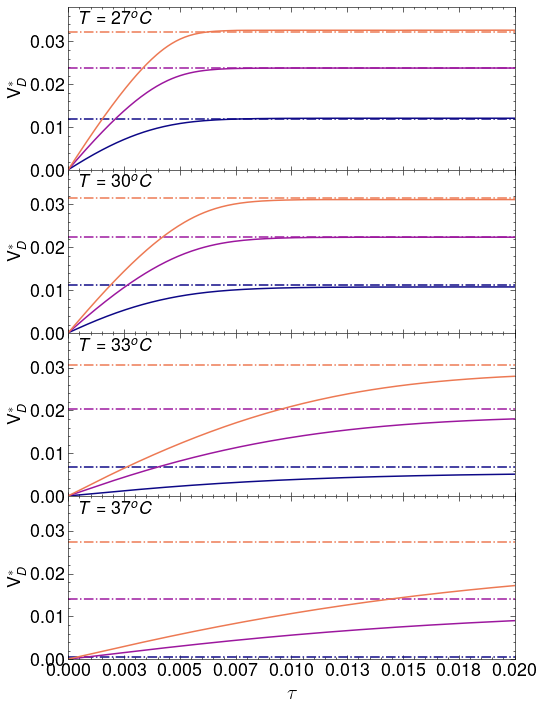

In [8]:
fig, axs = plt.subplots(4,1,figsize=(8,12),sharex=True,gridspec_kw={'hspace': 0})

cc=0
# Cycle over Temperatures
for i in np.arange(0,np.size(T_exp)): 
    # Color for different Ctot_s
    color=iter(cm.plasma(np.linspace(0,1,1+np.size(Ctot_exp))))
    
    # Cycle over Concentrations
    for j in np.arange(0,np.size(Ctot_exp)):
        guess=1E-8
        c=next(color)
        
        dFdt = lambda t, s:  -1*dFdV(s,SIGMAprime_exp[i], DmuE_exp[i], Ctot_exp[j], rhoL_exp[i], Ceq_exp[i], Vtot_exp)
        
        t_eval = np.logspace(-10, -1.5, 1000)
        sol = solve_ivp(dFdt, [0, 2E-1], [1E-4], t_eval=t_eval)
        axs[i].plot([0, 5E-2],[VDstar_exp[cc],VDstar_exp[cc]],'-.',c=c)
        axs[i].plot(sol.t, sol.y[0],c=c)
        axs[i].set_ylim([0, 0.038])
        axs[i].set_xlim([0, 0.02])
        axs[i].set_ylabel('V$_D^*$')
        cc+=1
        
axs[0].text(0.0005,0.034,'$T=27^oC$')
axs[1].text(0.0005,0.034,'$T=30^oC$')
axs[2].text(0.0005,0.034,'$T=33^oC$')
axs[3].text(0.0005,0.034,'$T=37^oC$')
axs[3].set_xlabel('$\\tau$',fontsize=20)
axs[3].xaxis.set_major_formatter(FormatStrFormatter('% 1.3f'))        
plt.savefig('dynamics', dpi=600, bbox_inches='tight')
plt.show()


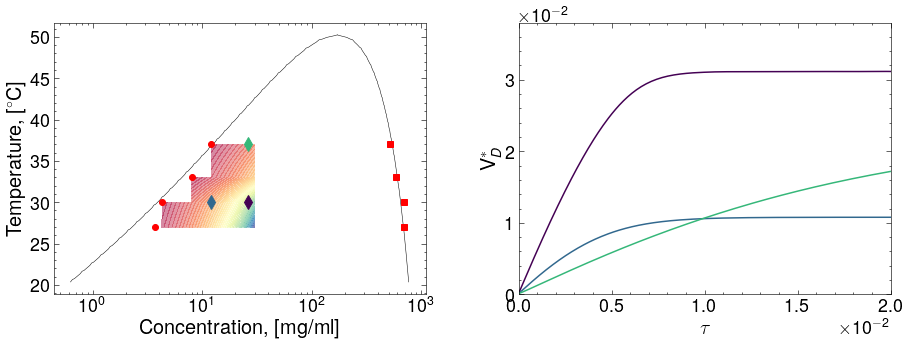

In [9]:
import pandas as pd
fig, axs = plt.subplots(1,2,figsize=(15,5),gridspec_kw={'wspace': 0.25})
df = pd.read_excel(r'coexistence_curves_data_UCST_Brady_UCP.xlsx')
axs[0].plot(df.iloc[:,1],df.iloc[:,0]-273.15,'-k',linewidth=.5)
axs[0].plot(df.iloc[:,2],df.iloc[:,0]-273.15,'-k',linewidth=.5)
axs[0].plot(Ceq_exp,T_exp,'ro')
axs[0].plot(rhoL_exp,T_exp,'rs')
axs[0].set_xscale('log')
axs[0].set_xlabel('Concentration, [mg/ml]',fontsize=20)
axs[0].set_ylabel('Temperature, [$^\circ$C]',fontsize=20)
color=iter(cm.viridis(np.linspace(0,1,1+np.size(Ctot_exp))))

i=1
j=2
c=next(color)
axs[0].plot(Ctot_exp[j],T_exp[i],'d',markersize=10,c=c)
dFdt = lambda t, s:  -1*dFdV(s,SIGMAprime_exp[i], DmuE_exp[i], Ctot_exp[j], rhoL_exp[i], Ceq_exp[i], Vtot_exp)
t_eval = np.logspace(-10, -1.5, 1000)
sol = solve_ivp(dFdt, [0, 2E-1], [1E-4], t_eval=t_eval)
axs[1].plot(sol.t, sol.y[0],c=c)
i=1
j=0
c=next(color)
axs[0].plot(Ctot_exp[j],T_exp[i],'d',markersize=10,c=c)
dFdt = lambda t, s:  -1*dFdV(s,SIGMAprime_exp[i], DmuE_exp[i], Ctot_exp[j], rhoL_exp[i], Ceq_exp[i], Vtot_exp)
t_eval = np.logspace(-10, -1.5, 1000)
sol = solve_ivp(dFdt, [0, 2E-1], [1E-4], t_eval=t_eval)
axs[1].plot(sol.t, sol.y[0],c=c)
i=3
j=2
c=next(color)
axs[0].plot(Ctot_exp[j],T_exp[i],'d',markersize=10,c=c)
dFdt = lambda t, s:  -1*dFdV(s,SIGMAprime_exp[i], DmuE_exp[i], Ctot_exp[j], rhoL_exp[i], Ceq_exp[i], Vtot_exp)
t_eval = np.logspace(-10, -1.5, 1000)
sol = solve_ivp(dFdt, [0, 2E-1], [1E-4], t_eval=t_eval)
axs[1].plot(sol.t, sol.y[0],c=c)
axs[1].set_ylim([0, 0.038])
axs[1].set_xlim([0, 0.02])
axs[1].set_ylabel('V$_D^*$',fontsize=20)
axs[1].set_xlabel('$\\tau$',fontsize=20)


#Define Functions -> Critical Normalised Droplet Volume (macroscopic)
macroscopic_rate=lambda DmuE, Ctot, Ceq, : \
                                           np.log(Ctot/Ceq) + DmuE*(1-Ctot/Ceq)

Ctot_lim=np.linspace(1,30,500)

RATE=np.zeros([4,500])
CT_g,Ceq_g = np.meshgrid(Ctot_lim, Ceq_exp) 
CT_g,T_g   = np.meshgrid(Ctot_lim, T_exp) 

# Color for different Ts
color=iter(cm.Spectral(np.linspace(0,1,np.size(T_exp))))
    

# Cycle over Temperatures
for i in np.arange(0,np.size(T_exp)): 
    c=next(color)
    # Cycle over Concentrations
    for j in np.arange(0,np.size(Ctot_lim)):
         
        RATE[i,j]=macroscopic_rate(DmuE_exp[i], Ctot_lim[j],Ceq_exp[i])
        if RATE[i, j] < 0: 
            RATE[i , j]=np.NaN
            
cp=axs[0].contourf(CT_g,T_g,RATE,50,cmap='Spectral',antialiased=False,alpha=0.5);

plt.ticklabel_format(axis='both', style='sci', scilimits=(-2,2))
fig.tight_layout()

plt.savefig('phase_diagram_dynamics', dpi=600, bbox_inches='tight')
plt.savefig('phase_diagram_dynamics_vector', dpi=600, bbox_inches='tight', format='svg') 





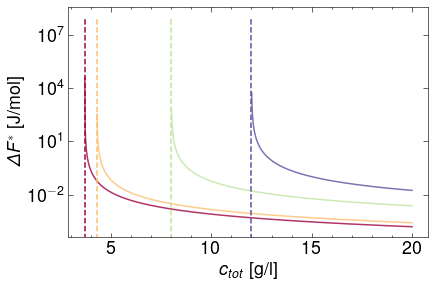

In [10]:
Ctot_lim=np.linspace(1,20,1000)

BARRIER=np.zeros([4,1000])
CRITICAL_VOLUME=np.zeros([4,1000])
BARRIER_macroL=np.zeros([4,1000])
CRITICAL_VOLUME_macroL=np.zeros([4,1000])
CT_g,Ceq_g = np.meshgrid(Ctot_lim, Ceq_exp) 
CT_g,T_g   = np.meshgrid(Ctot_lim, T_exp) 

figure=plt.figure();
axes = figure.add_axes([0.1,0.1,1.,0.8]);

# Color for different Ts
color=iter(cm.Spectral(np.linspace(0,1,np.size(T_exp))))
    

# Cycle over Temperatures
for i in np.arange(0,np.size(T_exp)): 
    c=next(color)
    # Cycle over Concentrations
    for j in np.arange(0,np.size(Ctot_lim)):
         
        CRITICAL_VOLUME_macroL[i,j]=criticalVmacro(SIGMAprime_exp[i], DmuE_exp[i], Ctot_lim[j], Ceq_exp[i], Vtot_exp)
        
        BARRIER_macroL[i,j]=R*(273.15+T_exp[i])*Fmacro(CRITICAL_VOLUME_macroL[i,j],SIGMAprime_exp[i], DmuE_exp[i], Ctot_lim[j], Ceq_exp[i], Vtot_exp)
        
    axes.plot(CT_g[i,:],BARRIER_macroL[i,:],'b-',alpha=0.8,c=c)
    axes.plot([Ceq_exp[i],Ceq_exp[i]],[0, 1E8],'--',c=c)

    
axes.set_yscale('log')
axes.set_xlabel('$c_{tot}$ [g/l]')
axes.set_ylabel('$\Delta{F}^*$ [J/mol]')
plt.show();

The dynamics of the droplet evolution is captured by the expression: 
\begin{equation}
\frac{dV^*_D}{dt}=-{D}\frac{dF'}{dV^*_D}
\end{equation}




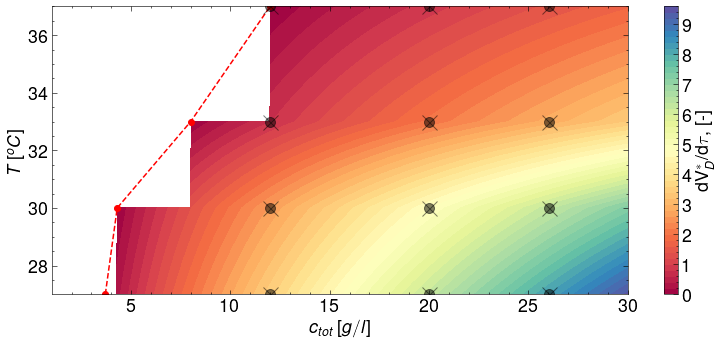

In [11]:
#Define Functions -> Critical Normalised Droplet Volume (macroscopic)
macroscopic_rate=lambda DmuE, Ctot, Ceq, : \
                                           np.log(Ctot/Ceq) + DmuE*(1-Ctot/Ceq)

Ctot_lim=np.linspace(1,30,500)

RATE=np.zeros([4,500])
CT_g,Ceq_g = np.meshgrid(Ctot_lim, Ceq_exp) 
CT_g,T_g   = np.meshgrid(Ctot_lim, T_exp) 

figure=plt.figure();
axes = figure.add_axes([0.1,0.1,2,1.0]);

# Color for different Ts
color=iter(cm.Spectral(np.linspace(0,1,np.size(T_exp))))
    

# Cycle over Temperatures
for i in np.arange(0,np.size(T_exp)): 
    c=next(color)
    # Cycle over Concentrations
    for j in np.arange(0,np.size(Ctot_lim)):
         
        RATE[i,j]=macroscopic_rate(DmuE_exp[i], Ctot_lim[j],Ceq_exp[i])
        if RATE[i, j] < 0: 
            RATE[i , j]=np.NaN

        
axes.plot(Ceq_exp,T_exp,'ro--')
        
cp=plt.contourf(CT_g,T_g,RATE,50,cmap='Spectral',antialiased=False,alpha=1.0);
cbar = plt.colorbar(cp, ax=axes)


CT_g,T_g   = np.meshgrid(Ctot_exp, T_exp) 
axes.plot(CT_g,T_g,'ko',markersize=10,alpha=0.5)
axes.plot(CT_g,T_g,'kx',markersize=15,alpha=0.5)
cbar.set_label("dV$_D^*$/d$\\tau$, [-]")
axes.set_ylabel('$T\,[^oC]$')
axes.set_xlabel('$c_{tot}\,[g/l]$')


plt.savefig('RATE', dpi=600, bbox_inches='tight');